In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/home/stargazer/workspace/catkin_ws/data.csv')
data

,Unnamed: 0,h,w,num,r,g,b
0,0,25,60,226,0.022124,9.261062,255.000000
1,1,28,60,288,1.118056,14.177083,255.000000
2,2,28,62,293,0.924915,14.969283,255.000000
3,3,22,63,124,1.314516,18.685484,255.000000
4,4,25,62,163,1.214724,19.521472,255.000000
...,...,...,...,...,...,...,...
139,139,20,61,97,10.783505,14.783505,190.628866
140,140,21,61,123,11.300813,15.308943,193.382114
141,141,21,61,134,12.059701,16.477612,188.947761
142,142,23,61,146,13.184932,15.705479,200.184932


In [3]:
data = np.load('/home/stargazer/workspace/catkin_ws/data.npy')
data.shape
## height, width, num_pix, hue, lightness, saturation

(6, 241)

In [4]:
data[:,:5]

array([[  0.        ,  14.        ,  17.        ,  18.        ,
         15.        ],
       [  0.        ,  38.        ,  35.        ,  37.        ,
         32.        ],
       [  0.        ,   3.        , 114.        , 132.        ,
         67.        ],
       [  0.        ,  14.33333333,  10.55263158,   9.36363636,
         11.56716418],
       [  0.        ,  15.        ,  29.94736842, 103.45454545,
         16.65671642],
       [  0.        ,   3.        , 114.        ,  47.        ,
         67.        ]])

In [2]:

def normalize(signal):
    return  (signal-min(signal))/(max(signal)-min(signal))

<ipython-input-6-b7635392c2dd>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(normalize(data[1,:]) / normalize(data[0,:]))


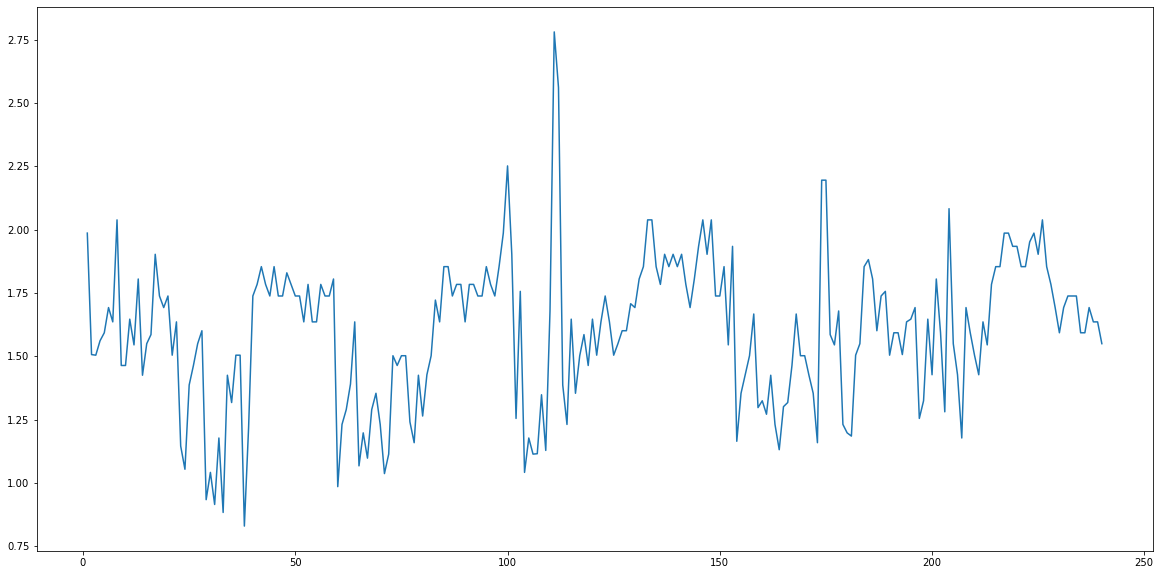

In [6]:
plt.figure(figsize = (20,10))
# plt.plot(normalize(data['h']))
# plt.plot(normalize(data['w']))
plt.plot(normalize(data[1,:]) / normalize(data[0,:]))

#plt.plot(data['h']/data['w'])

Text(0.5, 0, 'Frame')

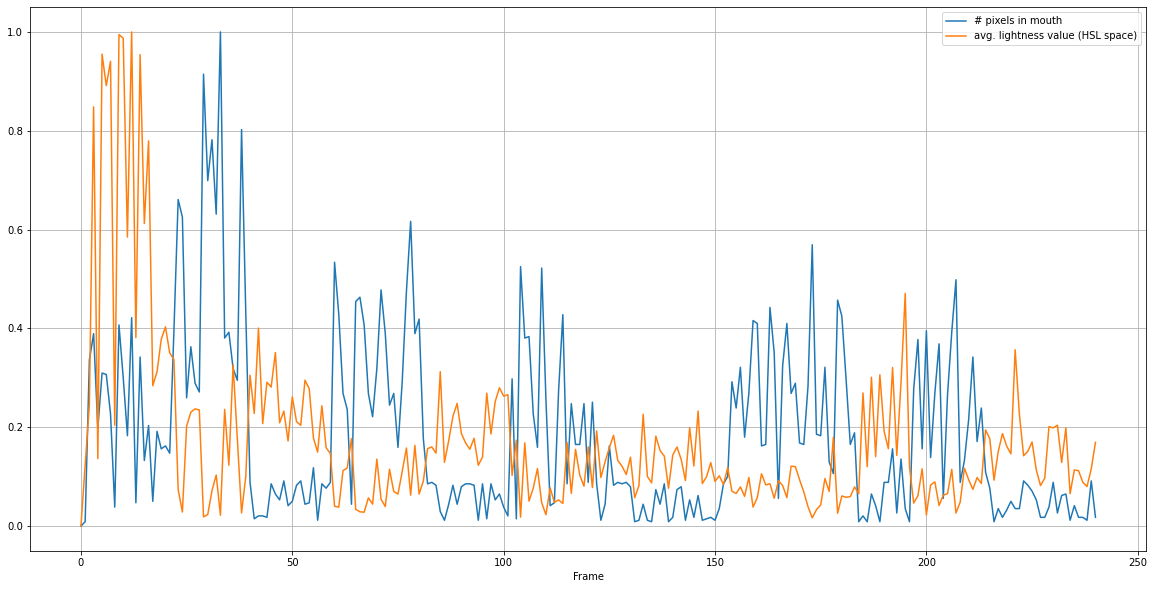

In [7]:
plt.figure(figsize = (20,10))
plt.plot(normalize(data[2,:]), label = '# pixels in mouth')
#plt.plot(normalize(data['h']))
plt.plot(normalize(data[4,:]), label = 'avg. lightness value (HSL space)')
plt.legend()
plt.grid()
plt.xlabel('Frame')

<ipython-input-8-ee6f5066520c>:4: RuntimeWarning: divide by zero encountered in true_divide
  z = x/np.roll(x, -1)


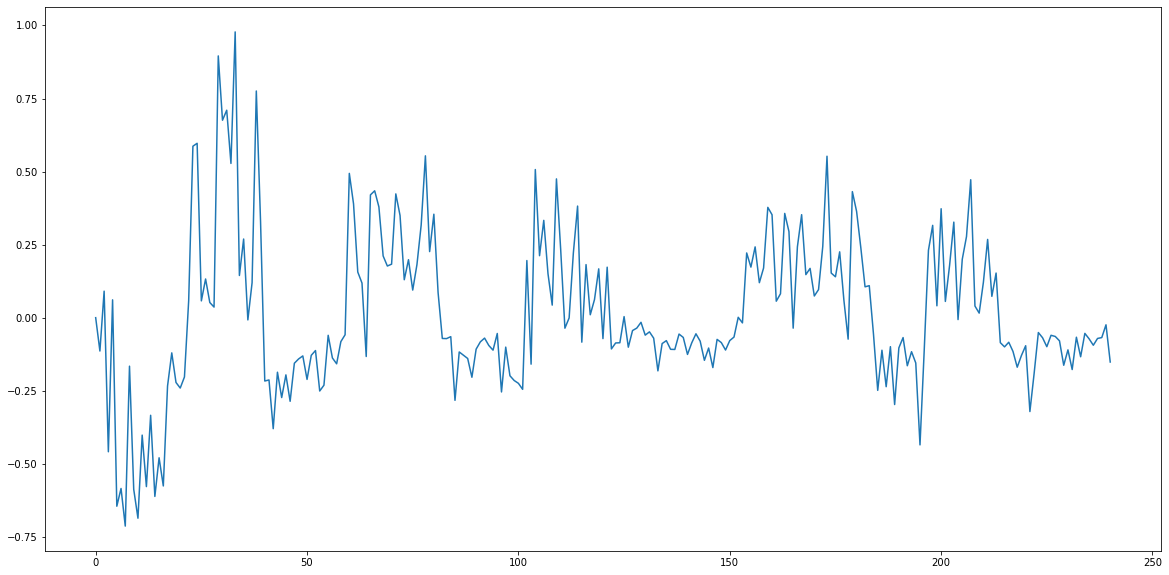

In [8]:
plt.figure(figsize = (20,10))
x = -normalize(data[4,:]) + normalize(data[2,:])
y = np.diff(x)
z = x/np.roll(x, -1)
plt.plot(x)

Text(0.5, 0, 'Frame')

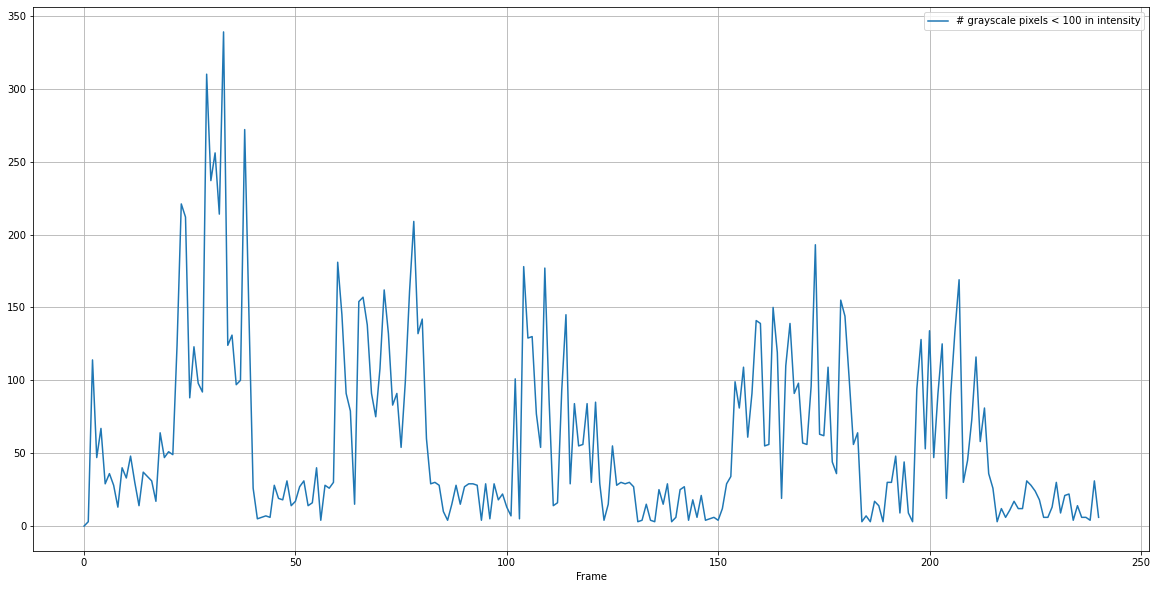

In [9]:
plt.figure(figsize = (20,10))
# plt.plot(data['r'])
# plt.plot(data['g'])
plt.plot(data[5,:], label = '# grayscale pixels < 100 in intensity')
plt.legend()
plt.grid()
plt.xlabel('Frame')

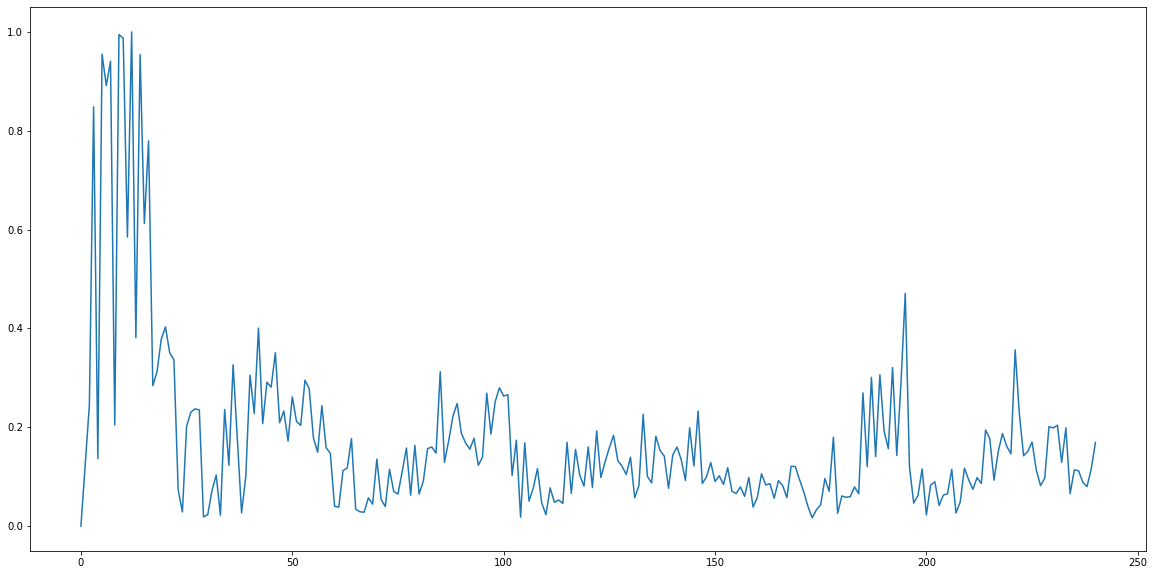

In [10]:
plt.figure(figsize = (20,10))
#plt.plot(data['r'])
plt.plot(normalize(data[4,:]))

In [3]:
import cv2

video = cv2.VideoCapture("/home/stargazer/workspace/catkin_ws/speech_test.mp4")
fps = video.get(cv2.CAP_PROP_FPS)
fps

23.970616663444808

In [12]:
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)
print( length/fps)

744
31.038


In [4]:
import numpy as np
import argparse
import imutils
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.path import Path
import dlib
from dlib import *
import cv2

def rect_to_bb(rect):

    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def mouth(shape, frame):
    idx = [60, 61, 62, 63, 64, 65, 66, 67]
    verts =shape[idx]
    verts = [(x,y) for x,y in verts]

    nx = frame.shape[0]
    ny = frame.shape[1]

    x, y = np.meshgrid(np.arange(ny), np.arange(nx))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    path = Path(verts)
    grid = path.contains_points(points)
    grid = grid.reshape((nx,ny))

    return grid

def outer_mouth(shape, frame):
    idx = list(range(48, 60))
    verts =shape[idx]
    verts = [(x,y) for x,y in verts]

    nx = frame.shape[0]
    ny = frame.shape[1]

    x, y = np.meshgrid(np.arange(ny), np.arange(nx))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x,y)).T

    path = Path(verts)
    grid = path.contains_points(points)
    grid = grid.reshape((nx,ny))

    return grid

def mouth_height(shape, frame):
    idx = [51, 57]
    verts =shape[idx]
    verts = [(x,y) for x,y in verts]

    height = verts[1][1] - verts[0][1]

    return height


def mouth_width(shape, frame):
    idx = [60, 64]
    verts =shape[idx]
    verts = [(x,y) for x,y in verts]

    width = verts[1][0] - verts[0][0]

    return abs(width)


def get_yaw_pitch(shape, frame):
    idx = 30
    h = frame.shape[0]//2
    w = frame.shape[1]//2

    displacement = (w-shape[idx][0], h-shape[idx][1])

    yaw = displacement[0]*80/640
    pitch = displacement[1]*50/480



    return yaw, pitch

In [196]:
import rospy
import cv2
from std_msgs.msg import Float32MultiArray
from sensor_msgs.msg import Image
from cv_bridge import CvBridge,CvBridgeError
import dlib
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/stargazer/workspace/catkin_ws/shape_predictor_68_face_landmarks.dat')

cap=cv2.VideoCapture("/home/stargazer/workspace/catkin_ws/speech_test.mp4")
print(cap.isOpened())
bridge=CvBridge()
pub=rospy.Publisher('/webcam',Float32MultiArray,queue_size=1000)
rospy.init_node('image',anonymous=False)
rate=rospy.Rate(80)

homs =[]
woms = []
num_pix = []
a_r=[]
a_g=[]
a_b=[]


stats = np.zeros((7,1))

total_num_pix = []
from PIL import Image

count = 0
while not rospy.is_shutdown():
    ret,frame=cap.read()
    
    if(ret == True):
        image = frame#imutils.resize(frame)
        #image = cv2.flip(image, -1)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        rects = detector(gray, 1)
        curr_stat = np.zeros((7,1))

        # loop over the face detections
        for (i, rect) in enumerate(rects):
            
            shape = predictor(gray, rect)
            shape = shape_to_np(shape)

            mouth_mask = mouth(shape, image)
            outer = outer_mouth(shape, image)

          #  (x, y, w, h) = fe.rect_to_bb(rect)
            final = np.zeros(gray.shape)
            final[outer] = 1
            pixels = np.sum(mouth_mask)#/np.sum(outer)
            dark = np.mean(gray[mouth_mask])

            height = mouth_height(shape, image)
            width = mouth_width(shape, image)
            low_light = np.mean(hsv[outer], axis = 0)
    
            disp = get_yaw_pitch(shape, image)
            print(low_light[1])
            # Display the landmarks
            # for i, (x, y) in enumerate(shape):
            #     # Draw the circle to mark the keypoint 
            #     cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
#             homs.append(height)
#             woms.append(width)
#             num_pix.append(pixels)
#             a_r.append(avg_rgb[0])
#             a_g.append(avg_rgb[1])
#             a_b.append(avg_rgb[2])
            
            a_r, a_g, a_b = np.mean(image[mouth_mask], axis = 0)

            curr_stat[:,0] =  np.array([height, width, pixels, low_light[0], low_light[1],low_light[2], dark]).T

        stats = np.concatenate((stats, curr_stat), axis =1)

        #out.write(image)
        # Display the image
        im = Image.fromarray(image)
        im.save("your_file.jpeg")
        cv2.putText(img = image, text = '# PIXELS: {}'.format(pixels),org = (50,50), fontScale = 2, color = (0,0,255), fontFace = 1)
        cv2.putText(img = image, text = 'AVG LIGHT: {}'.format(int(avg_rgb[1])),org = (50,70), fontScale = 2, color = (0,0,255), fontFace = 1)

        cv2.imshow('mouth mask', image)


       # cv2.imshow('Landmark Detection', image)
       # msg3=bridge.cv2_to_imgmsg(frame,"bgr8")
#         msg = Float32MultiArray()
#         msg.data = shape
#         # Press the escape button to terminate the code
#         pub.publish(msg)
#         rate.sleep()
        key=cv2.waitKey(30)
        if key==27:
            break
        if rospy.is_shutdown():
            cap.release()
    else:
        break
    
    count = count +1
    #print(count)

cap.release()
#out.release()
cv2.destroyAllWindows()


np.save('data.npy', stats)

True
6.765994741454864
7.31763698630137
7.305288461538462
6.42747358309318
6.586144029170465
7.2419898819561555
7.032258064516129
6.053308823529412
5.026881720430108
4.569405099150142
4.557471264367816
4.1157528285465625
4.036231884057971
3.8411654135338344
3.670818505338078
3.4438356164383563
3.3132108486439193
4.0008130081300814
3.523225241016652
4.111019055509527
3.570298769771529
4.117039586919105
4.426597582037997
4.246140651801029
3.7275204359673024
4.151785714285714
4.4246696035242294
4.397412199630314
4.004012036108325
4.0680933852140075
4.516129032258065
4.45
4.57039055404178
4.408108108108108
4.418164616840113
5.007017543859649
4.639857015192136
4.473588342440801
4.791917454858125
5.597560975609756
4.2020725388601035
4.059663865546218
4.611754966887418
3.9673826571201274
4.42814371257485
3.5052546483427647
4.681853281853281
5.2847533632287
6.1821974965229485
5.181060606060606
6.074452554744526
5.850768105340161
4.150814053127678
5.202152190622598
6.437722419928826
4.526595744

17.50363196125908
18.45484949832776
19.012057877813504
18.38893100833965
18.945988880063542
18.903703703703705
18.41324392288349
18.696864111498257
17.576625386996906
18.012366034624897
18.19254658385093
18.21902478017586
18.04679376083189
18.34970857618651
18.19858156028369
18.62211614956245
18.308477237048667
18.29183508488278
17.834267413931144
17.793998377939985
17.413961038961038
17.55874894336433
17.17313664596273
17.386834319526628
17.642635658914728
17.566443949517446
17.43717080511663
17.74903175832688
17.748818897637797
18.25977011494253
19.008634222919937
18.027966742252456
18.322607260726073
19.374117647058824
18.817817014446227
19.496012759170654
19.39113530326594
19.427015250544663
19.857794676806083
19.19333333333333
18.106333072713056
18.82905982905983
18.483216237314597
18.301932367149757
18.99265306122449
18.583739837398372
18.400757575757577
16.203779786359902
14.02557319223986
11.600556070435589
9.3488824101069
9.69032258064516
6.82249742002064
6.889641819941917
6.9

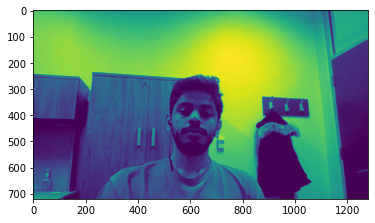

In [197]:
plt.imshow(gray)

In [198]:
gray

array([[182, 181, 179, ..., 148, 148, 148],
       [182, 182, 180, ..., 148, 148, 148],
       [182, 182, 182, ..., 148, 148, 148],
       ...,
       [144, 144, 144, ...,   0,   0,   0],
       [144, 144, 144, ...,   0,   0,   0],
       [144, 144, 144, ...,   0,   0,   0]], dtype=uint8)

In [199]:
gray[outer].shape

(1092,)

In [200]:
mouth_mask.shape

(720, 1280)

In [201]:
stats.shape

(7, 745)

In [202]:
# data = np.load('/home/stargazer/workspace/catkin_ws/data.npy')
# data.shape
data = stats

Text(0.5, 0, 'Frame')

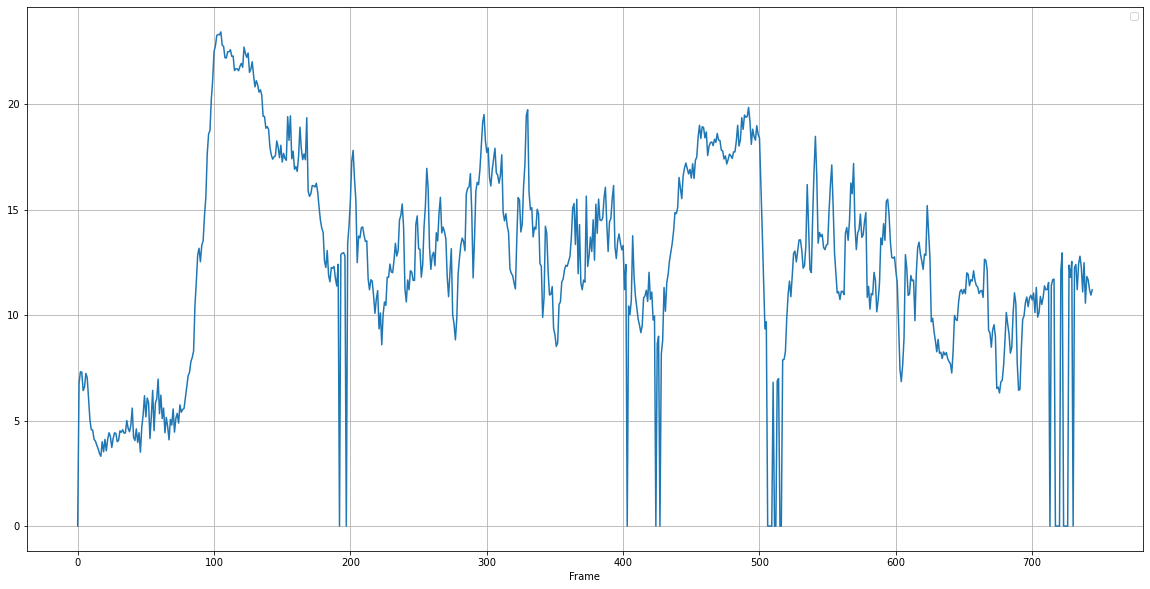

In [203]:
plt.figure(figsize = (20,10))
plt.plot(data[4,:])
plt.legend()
plt.grid()
plt.xlabel('Frame')

<ipython-input-204-1643c1af5c51>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(data[0,:]/data[1,:])


Text(0.5, 0, 'Frame')

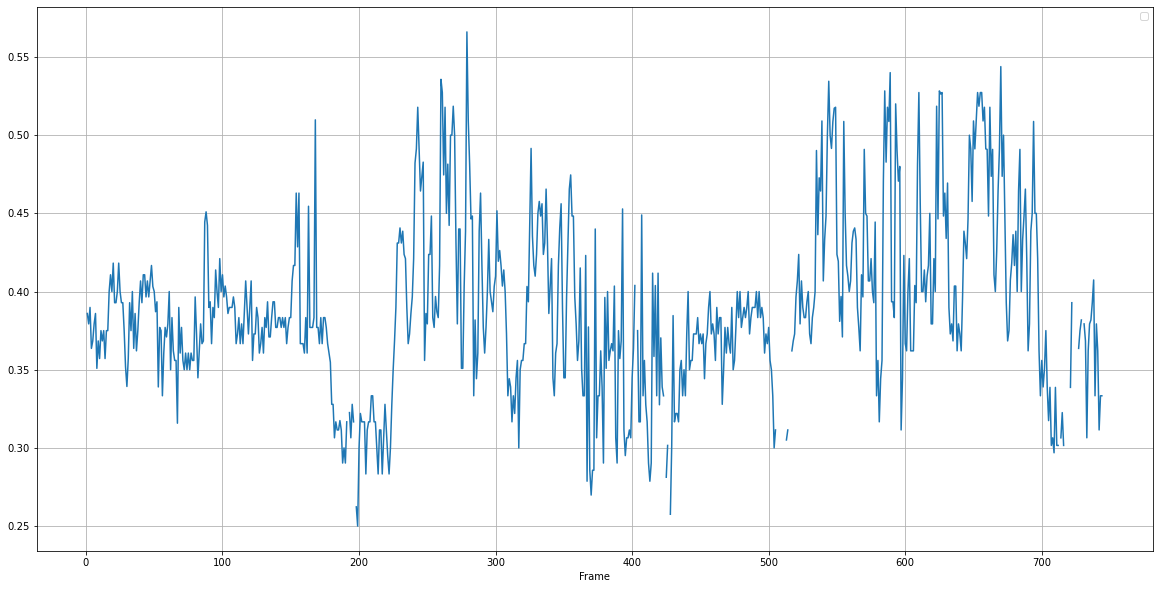

In [204]:
base_h = np.mean(data[0,:100])
y = data[0,:] > 1.1*base_h
plt.figure(figsize = (20,10))
#plt.plot((data[0,:]), label = 'height of mouth (pixels)')
plt.plot(data[0,:]/data[1,:])
#plt.plot(normalize(data['h']))
#plt.plot(normalize(data[4,:]), label = 'avg. lightness value (HSL space)')
plt.legend()
plt.grid()
plt.xlabel('Frame')

Text(0.5, 0, 'Frame')

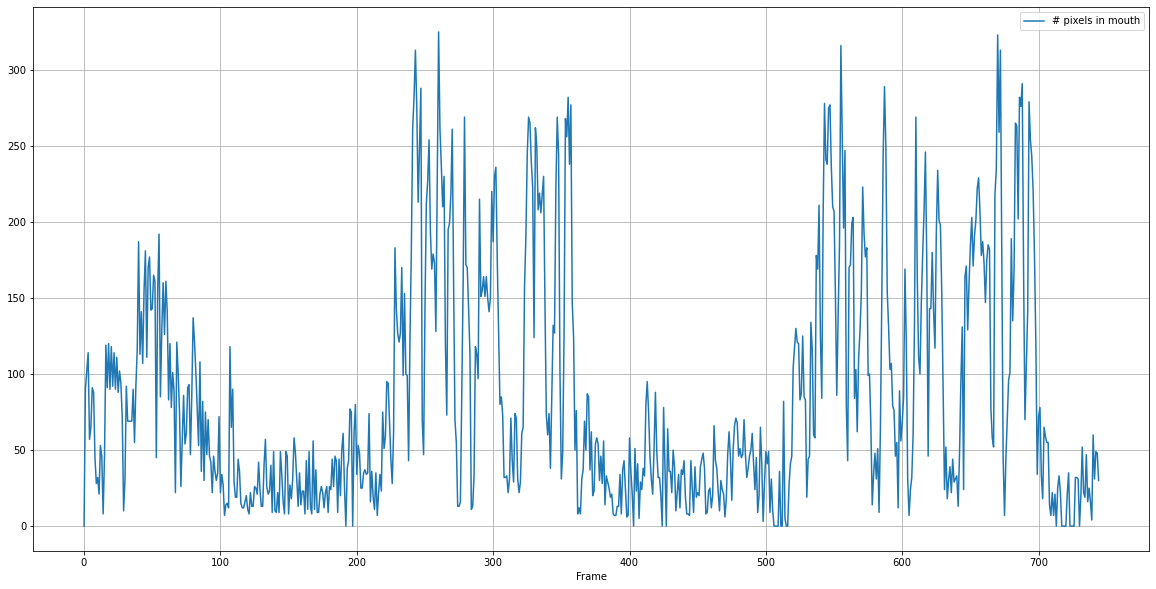

In [208]:
plt.figure(figsize = (20,10))
plt.plot((data[2,:]), label = '# pixels in mouth')

plt.legend()
plt.grid()
plt.xlabel('Frame')

Text(0.5, 0, 'Frame')

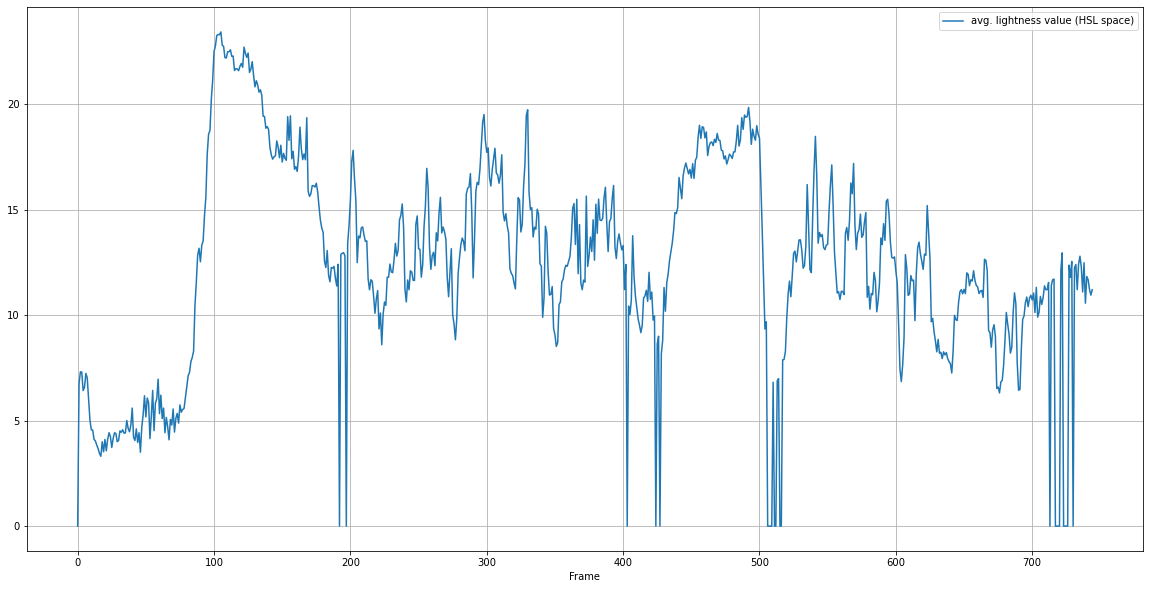

In [210]:
plt.figure(figsize = (20,10))
plt.plot((data[4,:]), label = 'avg. lightness value (HSL space)')

plt.legend()
plt.grid()
plt.xlabel('Frame')

<ipython-input-214-ee6f5066520c>:4: RuntimeWarning: divide by zero encountered in true_divide
  z = x/np.roll(x, -1)
<ipython-input-214-ee6f5066520c>:4: RuntimeWarning: invalid value encountered in true_divide
  z = x/np.roll(x, -1)


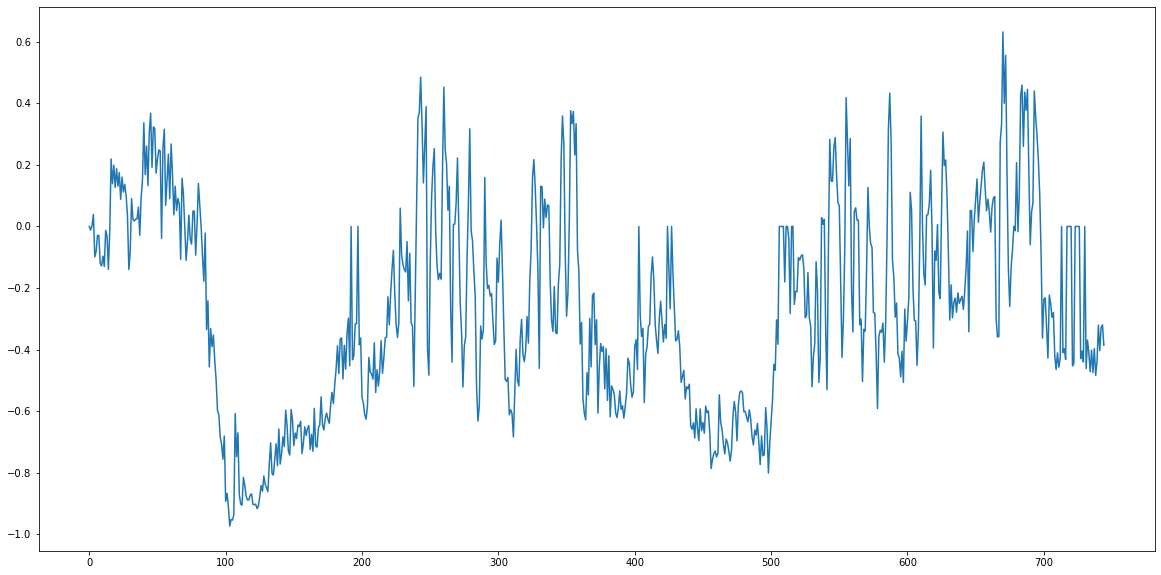

In [214]:
plt.figure(figsize = (20,10))
x = -normalize(data[4,:]) + normalize(data[2,:])
y = np.diff(x)
z = x/np.roll(x, -1)
plt.plot(x)

In [215]:
base= np.mean(data[5,:100])

x = data[5,:] > 1.5*base

<ipython-input-225-026312fdca5a>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((1/(data[6,:])), label = 'avg gray scale vals')


Text(0.5, 0, 'Frame')

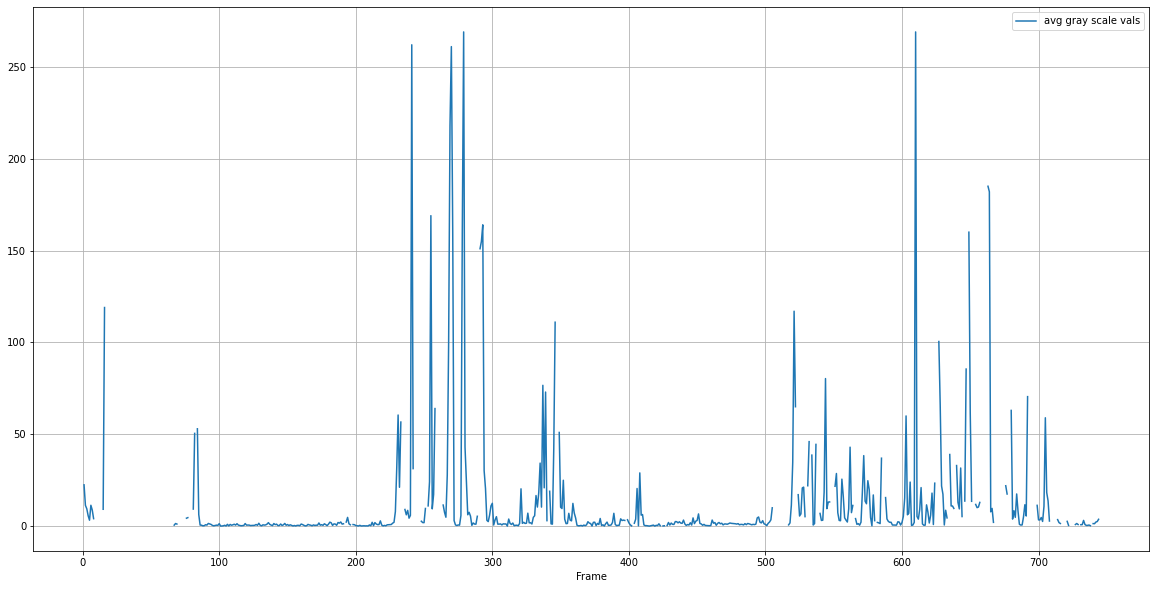

In [225]:
plt.figure(figsize = (20,10))

plt.plot((1/(data[6,:])), label = 'avg gray scale vals')

#plt.plot(x)
plt.legend()
plt.grid()
plt.xlabel('Frame')

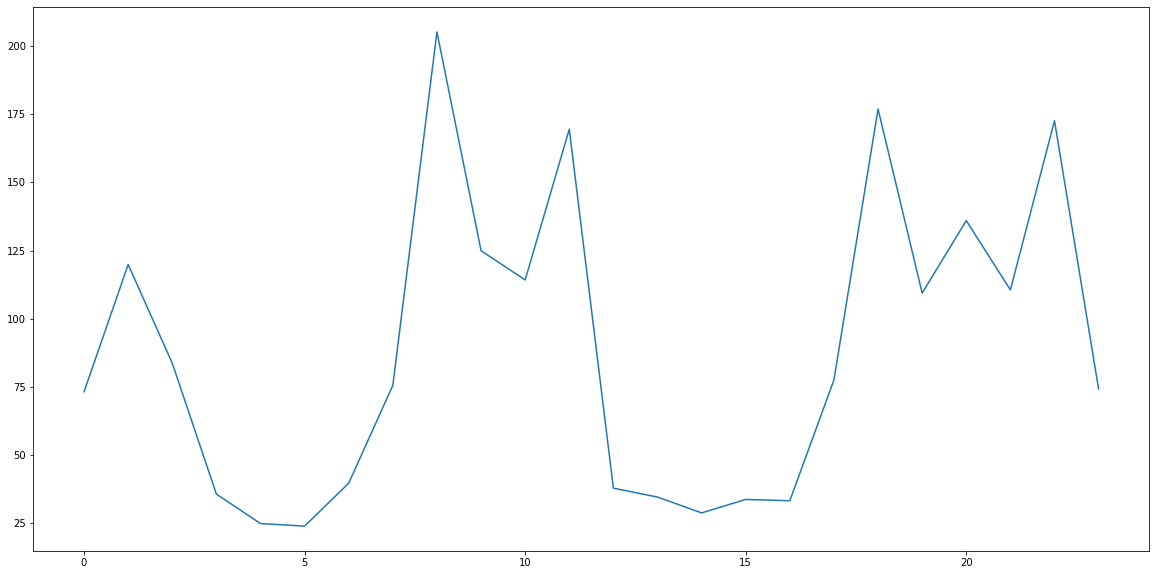

In [226]:
z = data[2,:720].reshape(-1,30)
plt.figure(figsize = (20,10))
plt.plot(np.mean(z, axis = 1))

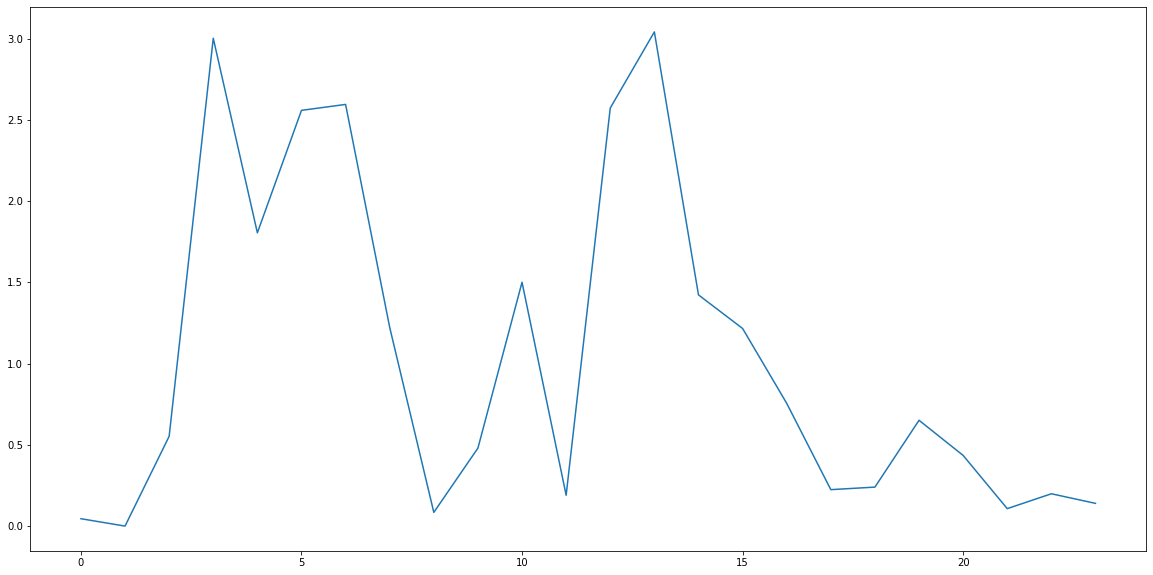

In [233]:
y = (data[6,:720]).reshape(-1,30)
plt.figure(figsize = (20,10))
plt.plot(np.mean(y, axis = 1))

In [219]:
base_e = np.sqrt(np.mean(data[2,:30]**2))
base_g = (np.mean(data[6,:30]))

base_e, base_g

(81.52566058201144, 0.04544441256061259)

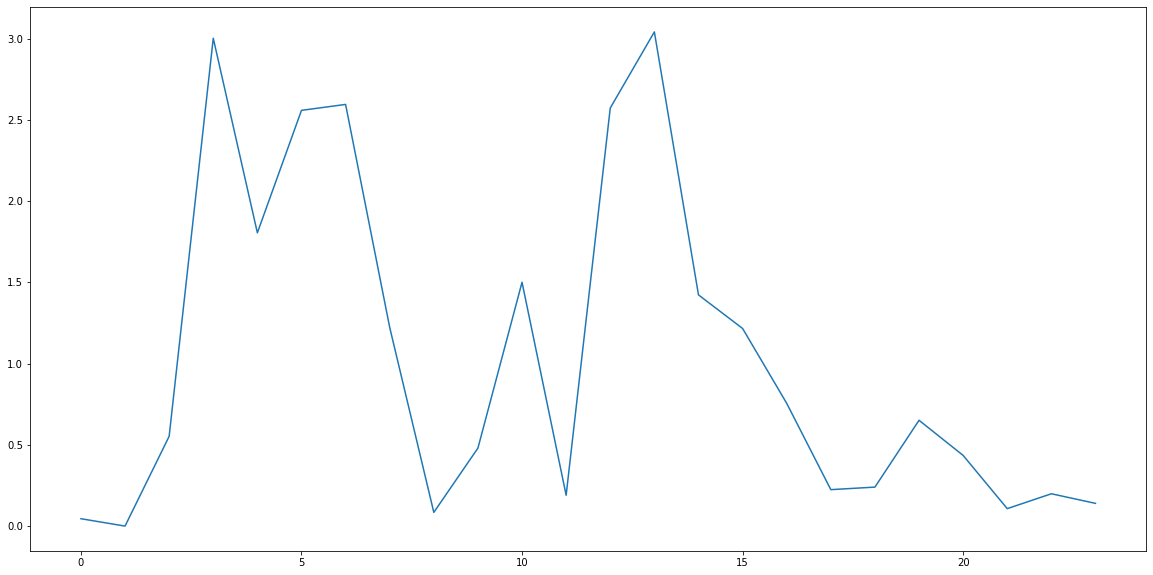

In [220]:
plt.figure(figsize = (20,10))
a = np.sqrt(np.mean(z**2, axis = 1))
b = (np.mean(y, axis = 1))

plt.plot(b)

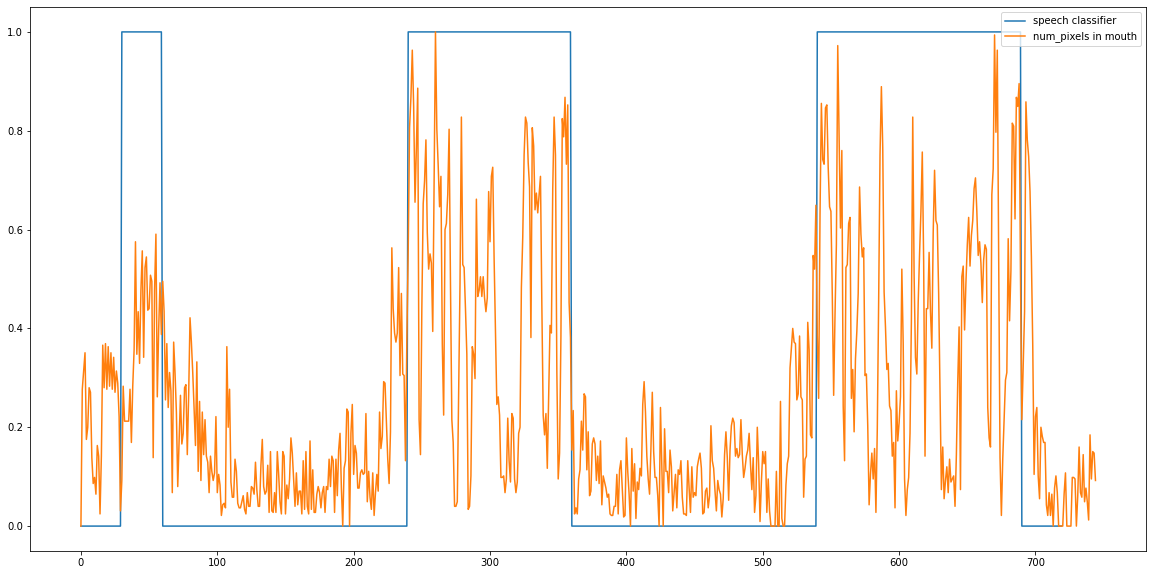

In [239]:
plt.figure(figsize = (20,10))
num_pix = np.repeat(a>base_e*1.5, 30)
num_gray = np.repeat(b > base_g*11, 30)
plt.plot(num_pix, label ='speech classifier')
plt.plot(normalize(data[2,:]), label = 'num_pixels in mouth')
plt.legend(loc = 'upper right')

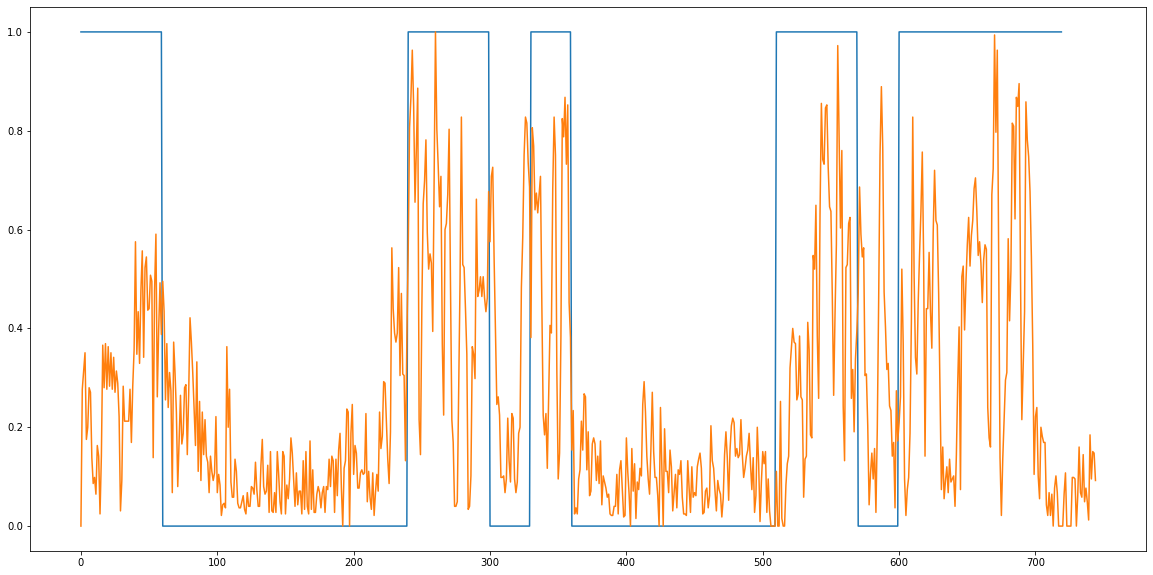

In [237]:
plt.figure(figsize = (20,10))
plt.plot(np.bitwise_not(num_gray))
plt.plot(normalize(data[2,:]))

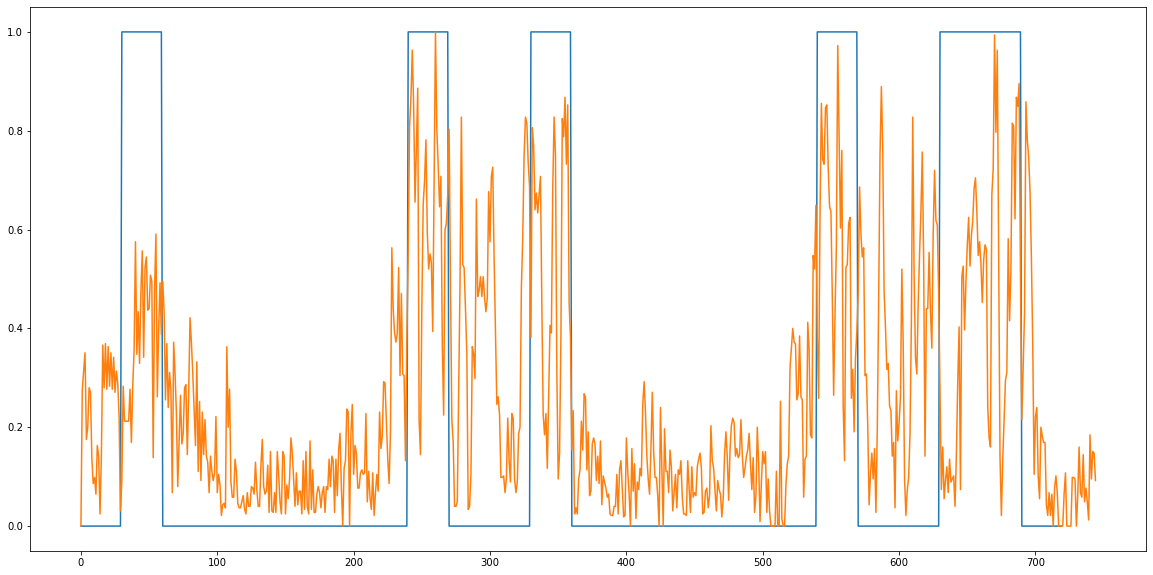

In [223]:
plt.figure(figsize = (20,10))
plt.plot(np.bitwise_and(np.bitwise_not(num_gray), num_pix))
plt.plot(normalize(data[2,:]))

In [13]:
def process_npix(total_num_pix, base_e,flag):
    if(flag ==0):
        base_e = np.sqrt(np.mean(np.array(total_num_pix)**2))
        return base_e
    
    elif(flag ==1):
        curr_energy = np.sqrt(np.mean(np.array(total_num_pix)**2))
        return curr_energy > base_e*1.5

In [16]:
import rospy
import cv2
from std_msgs.msg import Float32MultiArray
from sensor_msgs.msg import Image
from cv_bridge import CvBridge,CvBridgeError
import dlib
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/home/stargazer/workspace/catkin_ws/shape_predictor_68_face_landmarks.dat')

#cap=cv2.VideoCapture("/home/stargazer/workspace/catkin_ws/speech_test.mp4")
cap=cv2.VideoCapture(0)

print(cap.isOpened())
# bridge=CvBridge()
# pub=rospy.Publisher('/webcam',Float32MultiArray,queue_size=1000)
# rospy.init_node('image',anonymous=False)
# rate=rospy.Rate(80)

homs =[]
woms = []
num_pix = []
a_r=[]
a_g=[]
a_b=[]


stats = np.zeros((7,1))

total_num_pix = []
curr_speak = []
from PIL import Image

count = 0
flag = 0
base_e = 0
curr_e = 0
#while not rospy.is_shutdown():
while(True):
    ret,frame=cap.read()
    
    if(ret == True):
        image = frame#imutils.resize(frame)
        #image = cv2.flip(image, -1)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        rects = detector(gray, 1)
        curr_stat = np.zeros((7,1))

        # loop over the face detections
        for (i, rect) in enumerate(rects):
            
            shape = predictor(gray, rect)
            shape = shape_to_np(shape)

            mouth_mask = mouth(shape, image)
           
            pixels = np.sum(mouth_mask)#/np.sum(outer)
            total_num_pix.append(pixels)
            if(len(total_num_pix) == 30 and flag ==0):
                base_e = process_npix(total_num_pix, base_e, flag)
                flag = 1
                total_num_pix = []
            elif(len(total_num_pix) == 30 and flag == 1):
                curr_e = process_npix(total_num_pix,base_e,  flag)
                curr_speak.append(curr_e)
                total_num_pix = []
            print(count, base_e, curr_e)

            

        #out.write(image)
        # Display the image
        im = Image.fromarray(image)
        im.save("your_file.jpeg")
#         cv2.putText(img = image, text = '# PIXELS: {}'.format(pixels),org = (50,50), fontScale = 2, color = (0,0,255), fontFace = 1)
#         cv2.putText(img = image, text = 'AVG LIGHT: {}'.format(int(avg_rgb[1])),org = (50,70), fontScale = 2, color = (0,0,255), fontFace = 1)
        cv2.putText(img = image, text = 'SPEAK: {}'.format(curr_e),org = (50,50), fontScale = 2, color = (0,0,255), fontFace = 1)
        cv2.imshow('mouth mask', image)

        key=cv2.waitKey(30)
        if key==27:
            break
#         if rospy.is_shutdown():
#             cap.release()
    else:
        break
    
    count = count +1
    #print(count)

cap.release()
#out.release()
cv2.destroyAllWindows()


#np.save('data.npy', stats)

False


In [247]:
total_num_pix

[102,
 87,
 99,
 82,
 65,
 81,
 49,
 58,
 56,
 92,
 89,
 74,
 91,
 72,
 42,
 89,
 57,
 59,
 40,
 55,
 72,
 52,
 104,
 51,
 45,
 57,
 84,
 49,
 70,
 56,
 56,
 79,
 89,
 82,
 26,
 27,
 24,
 10,
 4,
 8,
 50,
 315,
 1201,
 1498,
 1568,
 1135,
 1590,
 1505,
 1632,
 1657,
 1736,
 1711,
 1805,
 1011,
 1575,
 1698,
 1045,
 1296,
 1228,
 1638,
 1730,
 1606,
 1625,
 1515,
 1201,
 1505,
 1813,
 1026,
 1517,
 1416,
 1345,
 1674,
 1614,
 1633,
 1477,
 1536,
 1579,
 1490,
 1369,
 1419,
 1376,
 1284,
 1038,
 991,
 1037,
 929,
 963,
 971,
 914,
 940,
 938,
 903,
 913,
 926,
 849,
 718,
 677,
 605,
 639,
 607,
 602,
 469,
 545,
 545,
 595,
 577,
 322,
 240,
 112,
 277,
 28,
 55,
 34,
 61,
 72,
 46,
 53,
 71,
 82,
 91,
 100,
 80,
 51,
 224,
 218,
 167]